# Tweet content categorization

In [ ]:
!pip install tweetnlp

using python 3.10

In [ ]:
from tweetnlp import TopicClassification, Sentiment, Irony, Hate, Offensive, Emotion, NER
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

topic_model = TopicClassification()
sentiment_model = Sentiment()
irony_model = Irony()
hate_model = Hate()
offensive_model = Offensive()
emotion_model = Emotion()
entity_model = NER()

## Visualization of the models result

In [4]:
class TweetAnalysisPlots:
    def update_layout(self, ax, title, xlabel='Labels', ylabel='Probabilities', y_range=[0, 1]):
        ax.set_title(title, fontsize=16)
        ax.set_xlabel(xlabel, fontsize=14)
        ax.set_ylabel(ylabel, fontsize=14)
        ax.set_ylim(y_range)
        ax.tick_params(axis='both', labelsize=12)
        plt.xticks(rotation=90)

    def plot_probabilities(self, title, data):
        fig, ax = plt.subplots(figsize=(12, 6))
        probabilities = data['probability']
        labels = list(probabilities.keys())
        values = list(probabilities.values())
        ax.bar(labels, values)
        self.update_layout(ax, title)
        plt.tight_layout()
        plt.show()

    def plot_combined_probabilities(self, title, data, xlabel='Labels', ylabel='Probabilities'):
        fig, ax = plt.subplots(figsize=(12, 6))
        labels = list(data.keys())
        values = list(data.values())
        ax.bar(labels, values)
        self.update_layout(ax, title, xlabel, ylabel)
        plt.tight_layout()
        plt.show()

    def run(self, tweet):
        self.plot_probabilities('Topic Classification Probabilities', topic_model.topic(tweet, return_probability=True))
        self.plot_probabilities('Sentiment Probabilities', sentiment_model.sentiment(tweet, return_probability=True))
        self.plot_probabilities('Emotion Probabilities', emotion_model.emotion(tweet, return_probability=True))
        
        combined_probs = {
            'Irony': irony_model.irony(tweet, return_probability=True)['probability']['irony'],
            'Hate': hate_model.hate(tweet, return_probability=True)['probability']['HATE'],
            'Offensive': offensive_model.offensive(tweet, return_probability=True)['probability']['offensive']
        }
        self.plot_combined_probabilities('Irony, Hate, Offensive Probabilities', combined_probs)
        
        ner_results = entity_model.ner(tweet, return_probability=True)
        ner_probs = {'probability': {f"{result['type']}:{result['entity']}": result['probability'] for result in ner_results}}
        self.plot_probabilities('Entity Identification', ner_probs)

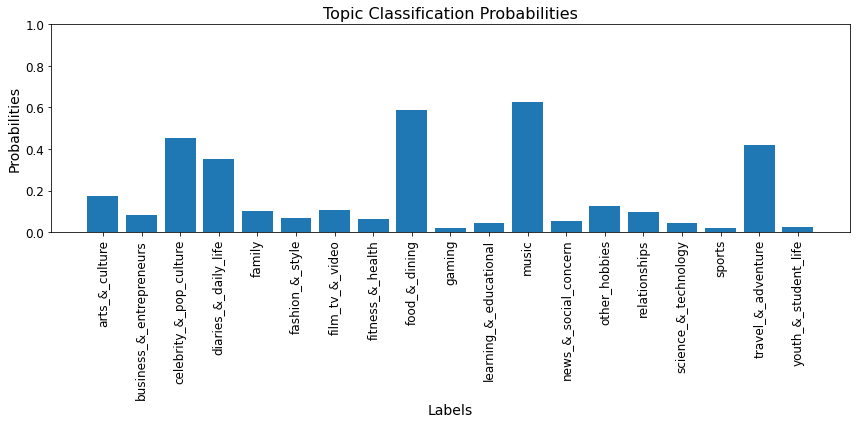

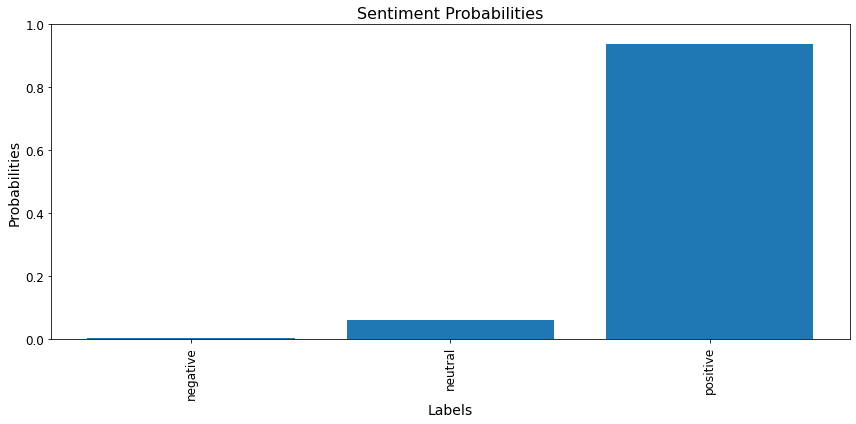

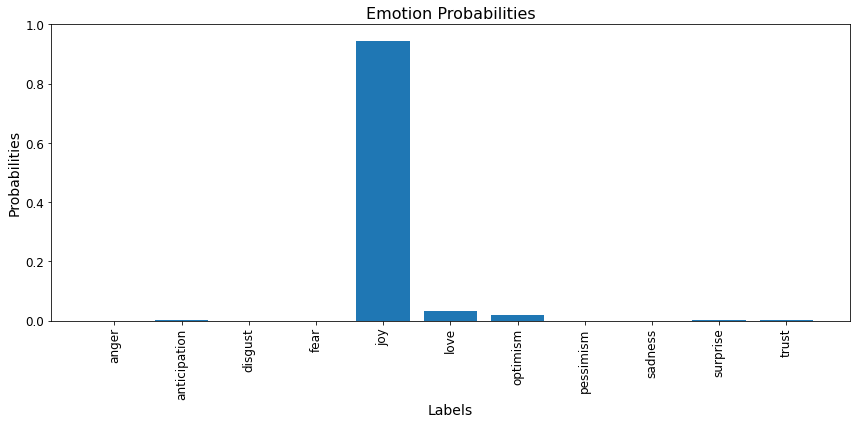

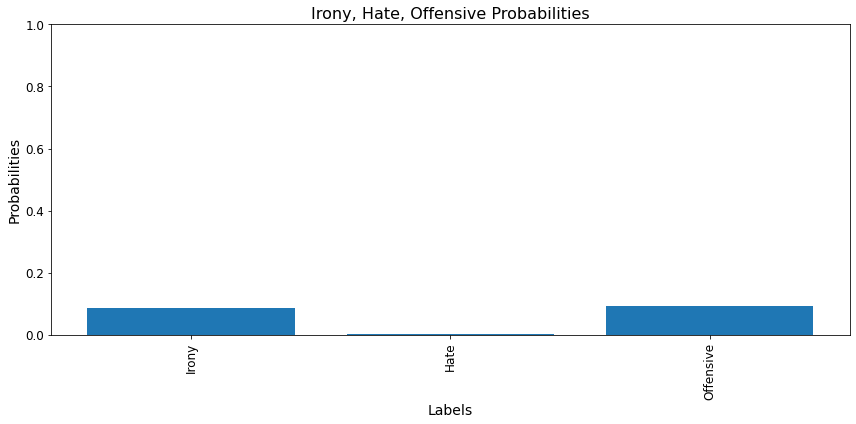

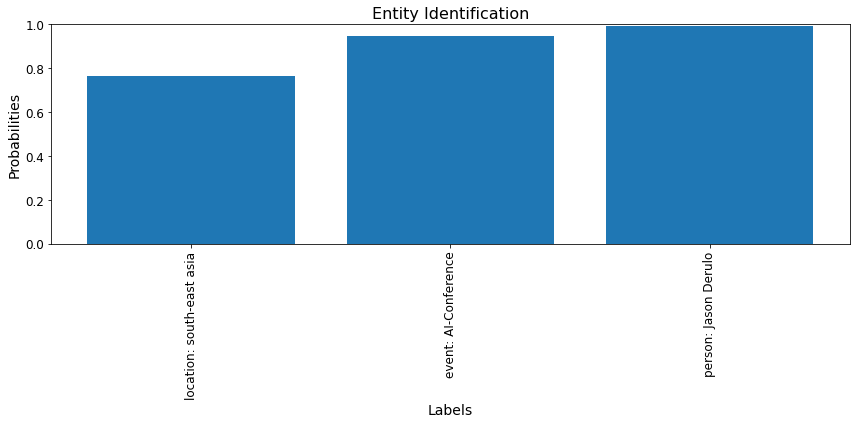

In [5]:
tweetanalysisplots = TweetAnalysisPlots()

tweet="I would love to go to south-east asia, travel, eat some good meals, go the the AI-Conference and meet Jason Derulo"
tweetanalysisplots.run(tweet)

## Run Models for multiple tweets

In [14]:
class TweetAnalysis:
    def __init__(self):
        self.data = []
    
    def extract_probabilities(self, tweet):
        topic_probs = topic_model.topic(tweet, return_probability=True)['probability']
        sentiment_probs = sentiment_model.sentiment(tweet, return_probability=True)['probability']
        return {
            'topic_probs': topic_probs,
            'sentiment_probs': sentiment_probs,
        }
    
    def analyze_tweets(self, tweets):
        for i, (user_id, tweet) in enumerate(tweets):
            if i % 1000 == 0:
                print(f"{i} tweets analyzed")
            probabilities = self.extract_probabilities(tweet)
            probabilities['user_ID'] = user_id
            probabilities['tweet'] = tweet
            self.data.append(probabilities)
    
    def flatten_and_compute_adjusted_variance(self):
        # Flatten the data
        flat_data = []
        for entry in self.data:
            flat_entry = {}
            for key, value in entry.items():
                if key == 'topic_probs':
                    for sub_key, sub_value in value.items():
                        flat_entry[f"{key}_{sub_key}"] = sub_value
                else:
                    flat_entry[key] = value
            flat_data.append(flat_entry)
        df = pd.DataFrame(flat_data)
        df.to_csv("flatten_data.csv")
        
        # Select probability columns
        numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
        df_content_prob = df[numeric_columns].copy()
        df_content_prob['user_ID'] = df['user_ID']
        
        # Group by user_ID and compute the sum for each topic
        grouped_sums = df_content_prob.groupby('user_ID').sum()

        # Normalize the probabilities per user so they add up to 1.
        normalization_factors = grouped_sums.sum(axis=1)
        grouped_sum_normalized = grouped_sums.div(normalization_factors, axis=0)

        # Compute variance for each topic
        grouped_variance_raw = df_content_prob.groupby('user_ID')[numeric_columns].var()
        grouped_variance_adjusted = grouped_variance_raw.div(normalization_factors, axis=0)

        # Combine normalized probabilities and adjusted variances
        combined = grouped_sum_normalized.add_suffix('_mean').join(grouped_variance_adjusted.add_suffix('_var'))

        return combined

    def save_normalized_and_adjusted_variance_to_csv(self, output_path):
        # Compute normalized probabilities and adjusted variance
        combined = self.flatten_and_compute_adjusted_variance()
        combined = round(combined, 4)
        combined.to_csv(output_path)

In [15]:
%%time

# Read the CSV file
input_file = "tweets.csv"  # Path to your CSV file
output_file = "aggregated_tweet_content_probabilities.csv"  # Path to save the results

# Load tweets into a DataFrame
df = pd.read_csv(input_file)

# Initialize TweetAnalysis and process the data
tweet_analysis = TweetAnalysis()
tweet_analysis.analyze_tweets(df[['user_id', 'tweet']].values.tolist())

# Save normalized probabilities and adjusted variances to a new CSV file
tweet_analysis.save_normalized_and_adjusted_variance_to_csv(output_file)

0 tweets analyzed
1000 tweets analyzed
2000 tweets analyzed
3000 tweets analyzed
4000 tweets analyzed
5000 tweets analyzed
6000 tweets analyzed
7000 tweets analyzed
8000 tweets analyzed
9000 tweets analyzed
10000 tweets analyzed
CPU times: user 3h 1min 59s, sys: 8.95 s, total: 3h 2min 8s
Wall time: 11min 23s


### Future Notes

- Decide how to aggregate by user. How do we consider the variance? 
- How to process the ner field? Is a convination of topic:probability...
- How do we treat the posting location and the ner fields? Onehot encoding?